In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../src/")
import json

import numpy as np
import pandas as pd
import math
from datasets import Dataset, list_metrics, load_metric
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from results_analysis.analyze_exp_results import ExpAnalyzer
from results_analysis.analyze_personalized_exp_results import PerPopulationExpAnalyzer
from results_analysis.analysis_utils import plot_user_perf_by_sample_count

from runners.runner_utils import loss_to_perplexity

In [3]:
base_result_dir = "/data/ddmg/redditlanguagemodeling/results/"

In [4]:
data_df = pd.read_csv("/data/ddmg/redditlanguagemodeling/data/3_all_data_user_filtered_2021-06-21.csv")

In [5]:
val_df = data_df[data_df["data_split"] == "val"]
test_users = set(val_df["author"])
len(test_users)

50

In [6]:
train_df = data_df[data_df["data_split"] == "train"]
user_counts = train_df.groupby("author").count()["id"]
user_counts = user_counts[user_counts.index.isin(test_users)]

In [7]:
test_df = data_df[data_df["data_split"] == "test"]

In [118]:
user_counts

author
BRoccoli20              21
Chad_arbc               30
Creative310             21
Dotabjj                 18
Eriflee                 19
GaniB                   19
HelloImLucas            20
IckyBelly               18
KarmaKingKong           66
Kennyv777               18
KharnTheBetrayer1997    19
MartEden                94
Olliebkl                18
Ps4gal94                52
Thatawkwardhipster      20
Tony0x01                22
Unclebunt92             21
WarKittyKat             31
americanpegasus         72
anonymous_user_x        21
binarygold              24
blossbloss              28
bluejeans90210          21
brookswilliams          39
closingbell             19
cqm                     32
cwrace71                18
davidcwilliams          35
eclecticuniversalas     19
eiidunncnsj             18
escapevelo              20
exab                    85
frostmas                33
glittertoes1            26
goodDayM                21
goodluckchuck11         40
hgmichna             

## Collect Results

In [30]:
result_dfs = []

In [31]:
# pre-trained model
rd1 = os.path.join(base_result_dir, "1_bert_distill_pretrained")
ea1 = ExpAnalyzer(rd1)
ea1.author_result_df["method"] = "pre-trained"
result_dfs.append(ea1.author_result_df)

In [32]:
#fine-tune all
rd_2b = os.path.join(base_result_dir, "2b_distilbert_finetuned_constant_lr")
ea_2b = ExpAnalyzer(rd_2b)
ea_2b.author_result_df["method"] = "fine-tune_all"
result_dfs.append(ea_2b.author_result_df)

In [33]:
#fine-tune user
rd_3a = os.path.join(base_result_dir, "3a_distilbert_finetuned_author_constant_lr")
ea_3a = PerPopulationExpAnalyzer(rd_3a, "author")
test_df_3a = ea_3a.data_split_perf_df[ea_3a.data_split_perf_df["data_split"] == "test"]
test_df_3a["method"] = "fine-tune_user"
test_df_3a.drop(columns="data_split", inplace=True)
result_dfs.append(test_df_3a)

Found results for 50 sub-populations


<ipython-input-33-00d32a5cf91f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_3a["method"] = "fine-tune_user"
/data/ddmg/users/kmatton/.conda/envs/rlm/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [34]:
#fine-tune subreddit
rd_4b = os.path.join(base_result_dir, "4b_distilbert_finetuned_subreddit_sample_eval")
ea_4b = PerPopulationExpAnalyzer(rd_4b, "subreddit")
merged_df_4b = ea_4b.sample_losses_df.merge(test_df, on="id", how="inner")
user_results_4b = merged_df_4b.groupby("author").mean()["loss"].to_frame()
user_results_4b["perplexity"] = user_results_4b["loss"].apply(lambda x: loss_to_perplexity(x))
user_results_4b["method"] = "fine-tune_subreddit"
result_dfs.append(user_results_4b.reset_index())

Found results for 6 sub-populations


In [35]:
# fine-tune all (2 epochs) + user (1 epoch)
rd_6_21 = os.path.join(base_result_dir, "6_distilbert_finetuned_all_author", "2_1_epochs_lr_5e-5")
ea_6_21 = PerPopulationExpAnalyzer(rd_6_21, "author")
test_df_6_21 = ea_6_21.data_split_perf_df[ea_6_21.data_split_perf_df["data_split"] == "test"]
test_df_6_21["method"] = "fine-tune_all_user"
test_df_6_21.drop(columns="data_split", inplace=True)
result_dfs.append(test_df_6_21)

Found results for 50 sub-populations


<ipython-input-35-7bf65ed8ba5a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_6_21["method"] = "fine-tune_all_user"


In [2]:
result_df = pd.concat(result_dfs)

NameError: name 'pd' is not defined

## Examine Per-User Results

In [53]:
result_df

,author,loss,perplexity,method
0,BRoccoli20,2.734233,15.397927,pre-trained
1,Chad_arbc,2.928797,18.705110,pre-trained
2,Creative310,3.261148,26.079471,pre-trained
3,Dotabjj,3.900943,49.449071,pre-trained
4,Eriflee,2.603933,13.516790,pre-trained
5,GaniB,2.536566,12.636204,pre-trained
6,HelloImLucas,2.977928,19.647074,pre-trained
7,IckyBelly,3.283250,26.662274,pre-trained
8,KarmaKingKong,3.053627,21.192074,pre-trained
9,Kennyv777,3.029405,20.684929,pre-trained


In [54]:
result_df = result_df.sort_values(["author", "perplexity"])
result_df = result_df.reset_index(drop=True)

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(result_df)

,author,loss,perplexity,method
0,BRoccoli20,1.992776,7.335873,fine-tune_all
1,BRoccoli20,2.007158,7.442139,fine-tune_all_user
2,BRoccoli20,2.011163,7.472005,fine-tune_subreddit
3,BRoccoli20,2.307036,10.044607,fine-tune_user
4,BRoccoli20,2.734233,15.397927,pre-trained
5,Chad_arbc,2.170573,8.763300,fine-tune_subreddit
6,Chad_arbc,2.293011,9.904718,fine-tune_all
7,Chad_arbc,2.344681,10.429948,fine-tune_all_user
8,Chad_arbc,2.633954,13.928733,fine-tune_user
9,Chad_arbc,2.928797,18.705110,pre-trained


In [1]:
# get top performing method for each user
idx = result_df.groupby("author")['perplexity'].transform(min) == result_df['perplexity']
best_method_df = result_df[idx]
best_method_df.sort_values("author")

NameError: name 'result_df' is not defined

In [65]:
best_method_results = best_method_df.groupby('method').count()
best_method_results

,author,loss,perplexity
method,,,
fine-tune_all,23,23,23
fine-tune_all_user,11,11,11
fine-tune_subreddit,16,16,16


In [69]:
best_method_results.rename(columns={"author": "author_count"}, inplace=True)
best_method_results.drop(columns=['loss', 'perplexity'], inplace=True)
best_method_results

,author_count
method,
fine-tune_all,23
fine-tune_all_user,11
fine-tune_subreddit,16


In [70]:
best_method_results["author_percent"] = best_method_results["author_count"].apply(lambda x: x * 100 / (16 + 11 + 23))

In [71]:
best_method_results

,author_count,author_percent
method,,
fine-tune_all,23,46.0
fine-tune_all_user,11,22.0
fine-tune_subreddit,16,32.0


In [85]:
user_pt_df = result_df[result_df["method"] == "pre-trained"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.10404020197247915, p=0.4721268670615528


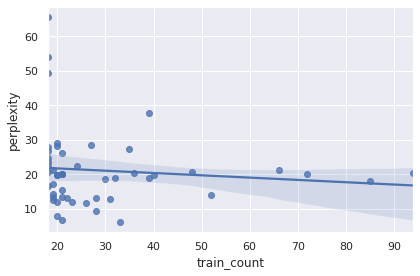

<Figure size 432x288 with 0 Axes>

In [88]:
plot_user_perf_by_sample_count(user_pt_df, user_counts, "perplexity")

In [89]:
user_ft_all_df = result_df[result_df["method"] == "fine-tune_all"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.09199716379598688, p=0.5251581753130459


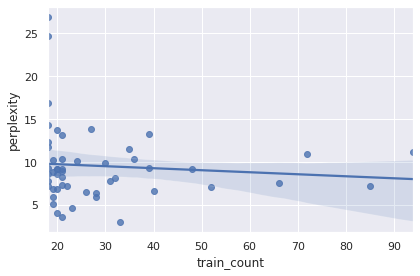

<Figure size 432x288 with 0 Axes>

In [90]:
plot_user_perf_by_sample_count(user_ft_all_df, user_counts, "perplexity")

In [91]:
user_ft_all_user_df = result_df[result_df["method"] == "fine-tune_all_user"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.08605786768973822, p=0.55235569259137


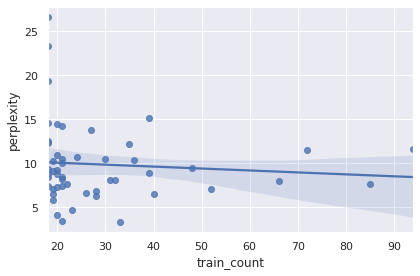

<Figure size 432x288 with 0 Axes>

In [92]:
plot_user_perf_by_sample_count(user_ft_all_user_df, user_counts, "perplexity")

In [105]:
norm_result_df = result_df.copy()
ri_result_df = result_df.set_index(["author", "method"])
for idx, row in norm_result_df.iterrows():
    author = row["author"]
    method = row["method"]
    pt_loss = ri_result_df.loc[(author, "pre-trained")]["loss"]
    pt_perplexity = ri_result_df.loc[(author, "pre-trained")]["perplexity"]
    norm_result_df.at[idx, "loss"] = pt_loss - norm_result_df.iloc[idx]["loss"]
    norm_result_df.at[idx, "perplexity"] = pt_perplexity - norm_result_df.iloc[idx]["perplexity"]

In [106]:
norm_result_df

,author,loss,perplexity,method
0,BRoccoli20,0.741457,8.062054,fine-tune_all
1,BRoccoli20,0.727075,7.955788,fine-tune_all_user
2,BRoccoli20,0.723070,7.925923,fine-tune_subreddit
3,BRoccoli20,0.427197,5.353320,fine-tune_user
4,BRoccoli20,0.000000,0.000000,pre-trained
5,Chad_arbc,0.758224,9.941811,fine-tune_subreddit
6,Chad_arbc,0.635786,8.800393,fine-tune_all
7,Chad_arbc,0.584116,8.275163,fine-tune_all_user
8,Chad_arbc,0.294843,4.776378,fine-tune_user
9,Chad_arbc,0.000000,0.000000,pre-trained


In [108]:
norm_user_ft_all_df = norm_result_df[norm_result_df["method"] == "fine-tune_all"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.10282031363703951, p=0.47736509693747226


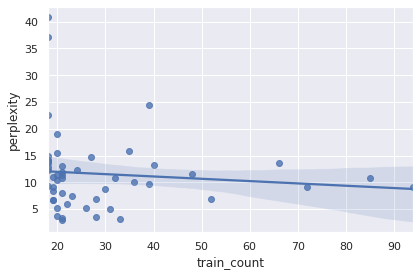

<Figure size 432x288 with 0 Axes>

In [110]:
plot_user_perf_by_sample_count(norm_user_ft_all_df, user_counts, "perplexity")

In [111]:
norm_user_ft_all_user_df = norm_result_df[norm_result_df["method"] == "fine-tune_all_user"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.10766494584245039, p=0.4567447171484962


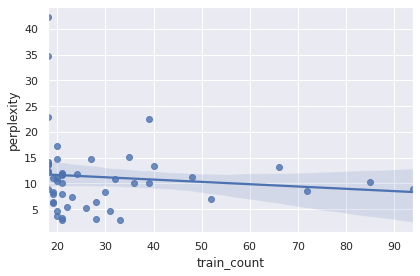

<Figure size 432x288 with 0 Axes>

In [112]:
plot_user_perf_by_sample_count(norm_user_ft_all_user_df, user_counts, "perplexity")

In [113]:
user_ft_user_df = result_df[result_df["method"] == "fine-tune_user"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.12353441229049418, p=0.39271337311268834


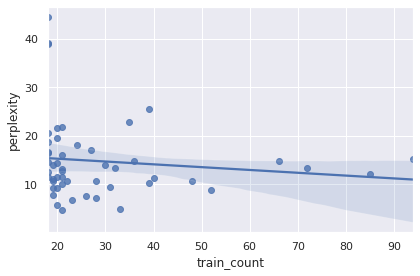

<Figure size 432x288 with 0 Axes>

In [114]:
plot_user_perf_by_sample_count(user_ft_user_df, user_counts, "perplexity")

In [117]:
user_ft_user_df

,author,loss,perplexity,method,train_count
3,BRoccoli20,2.307036,10.044607,fine-tune_user,21
8,Chad_arbc,2.633954,13.928733,fine-tune_user,30
13,Creative310,3.080813,21.776103,fine-tune_user,21
18,Dotabjj,3.668696,39.200743,fine-tune_user,18
23,Eriflee,2.370156,10.699057,fine-tune_user,19
27,GaniB,2.067019,7.901232,fine-tune_user,19
33,HelloImLucas,2.668136,14.413073,fine-tune_user,20
38,IckyBelly,2.930874,18.744003,fine-tune_user,18
43,KarmaKingKong,2.694591,14.799462,fine-tune_user,66
48,Kennyv777,2.525397,12.495850,fine-tune_user,18


In [115]:
norm_user_ft_user_df = norm_result_df[norm_result_df["method"] == "fine-tune_user"]

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.03843123583600911, p=0.7910291811703486


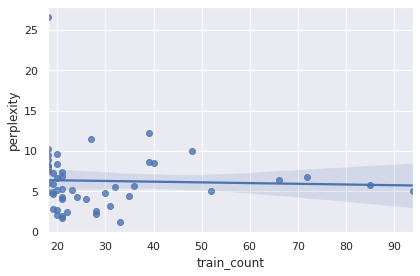

<Figure size 432x288 with 0 Axes>

In [116]:
plot_user_perf_by_sample_count(norm_user_ft_user_df, user_counts, "perplexity")

## Examine Per-Subreddit Results

In [72]:
subreddit_result_dfs = []

In [74]:
# pre-trained
ea1.sr_result_df["method"] = "pre-trained"
subreddit_result_dfs.append(ea1.sr_result_df)

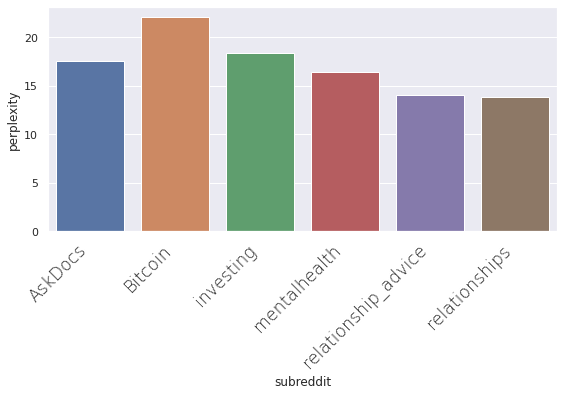

<Figure size 432x288 with 0 Axes>

In [79]:
ea1.plot_perf_by_subreddit("perplexity")

In [75]:
# fine-tune all
ea_2b.sr_result_df["method"] = "fine-tune_all"
subreddit_result_dfs.append(ea_2b.sr_result_df)

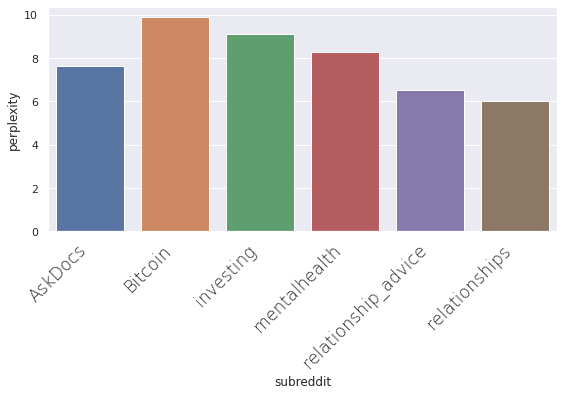

<Figure size 432x288 with 0 Axes>

In [80]:
ea_2b.plot_perf_by_subreddit("perplexity")

In [76]:
# fine-tune subreddit
rd_4a = os.path.join(base_result_dir, "4a_distilbert_finetuned_subreddit_constant_lr")
ea_4a = PerPopulationExpAnalyzer(rd_4a, "subreddit")
test_df_4a = ea_4a.data_split_perf_df[ea_4a.data_split_perf_df["data_split"] == "test"]
test_df_4a["method"] = "fine-tune_subreddit"
test_df_4a.drop(columns="data_split", inplace=True)
subreddit_result_dfs.append(test_df_4a)

Found results for 6 sub-populations


<ipython-input-76-99d9cdba1a5a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_4a["method"] = "fine-tune_subreddit"
/data/ddmg/users/kmatton/.conda/envs/rlm/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [77]:
sr_result_df = pd.concat(subreddit_result_dfs)

In [78]:
sr_result_df

,subreddit,loss,perplexity,method
0,AskDocs,2.864969,17.548514,pre-trained
1,Bitcoin,3.092544,22.033050,pre-trained
2,investing,2.907862,18.317588,pre-trained
3,mentalhealth,2.795626,16.372878,pre-trained
4,relationship_advice,2.643820,14.066840,pre-trained
5,relationships,2.624953,13.803919,pre-trained
0,AskDocs,2.034083,7.645239,fine-tune_all
1,Bitcoin,2.291048,9.885288,fine-tune_all
2,investing,2.207870,9.096321,fine-tune_all
3,mentalhealth,2.115519,8.293890,fine-tune_all


In [82]:
sr_result_df.sort_values(["subreddit", "loss"])

,subreddit,loss,perplexity,method
0,AskDocs,2.034083,7.645239,fine-tune_all
2,AskDocs,2.092766,8.107306,fine-tune_subreddit
0,AskDocs,2.864969,17.548514,pre-trained
1,Bitcoin,2.291048,9.885288,fine-tune_all
2,Bitcoin,2.291697,9.891705,fine-tune_subreddit
1,Bitcoin,3.092544,22.033050,pre-trained
2,investing,2.207870,9.096321,fine-tune_all
2,investing,2.260057,9.583633,fine-tune_subreddit
2,investing,2.907862,18.317588,pre-trained
3,mentalhealth,2.115519,8.293890,fine-tune_all
